# ResNeuroKin-D: Multi-Task Motor-Visual Decoder with Kinematic Structure Regularization

## Overview

This notebook extends the basic NeuroKin approach with a more sophisticated architecture that learns two related tasks simultaneously: predicting robot visual appearance and learning a geometric belief state. The idea is that both visual and geometric cues are important for understanding robot poses. By training on both tasks together, the network can learn richer representations that might not emerge from only predicting one output. We use heuristic depth targets to regularize the latent space, forcing the network to internalize 3D kinematic structure without requiring external depth sensors.

The architecture uses residual blocks in the decoder, which helps with training stability and allows for deeper networks. The model takes the same 4 joint angles as input but now produces two separate outputs: a binary visual mask and a depth map. Both outputs are 100×100 in size.

## Environment Setup

In [1]:
# Install required packages
!pip install -q gdown pybullet tqdm matplotlib torch scikit-image

import os
import sys
import time
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm, trange
from typing import Tuple, List, Optional

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ CUDA Version: {torch.version.cuda}")
    print(f"✓ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Set seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("✓ Environment configured")

Device: cuda
✓ GPU: Tesla T4
✓ CUDA Version: 12.6
✓ GPU Memory: 15.83 GB
✓ Environment configured


## 2. Data Preparation

The data comes from the same PyBullet simulation as before. Each sample has joint angles and a visual silhouette image. We download and prepare this data, then split it into training and testing sets. The images need to be normalized to the range [0, 1] and converted to grayscale format.

The dataset contains 2000 samples total. After splitting with an 80/20 ratio, we get 1600 training samples and 400 test samples. This relatively small dataset means the model needs to learn effectively from limited examples, which is why techniques like data augmentation (adding noise to angles) become important.

In [2]:
import gdown

os.makedirs('data', exist_ok=True)
os.makedirs('RobotArmURDF/4dof_1st/urdf', exist_ok=True)

data_url = 'https://drive.google.com/uc?id=1TVzU_-xblSQ7QM30MHXWNOt2Rl3hmpr3'
data_path = 'data/sim_data_robo1_lorenz_colab_2000.npz'

if not os.path.exists(data_path):
    print("Downloading dataset...")
    gdown.download(data_url, data_path, quiet=False)

urdf_url = 'https://drive.google.com/uc?id=1bBogWAaYzGWMJJQUHD10b45o_0asLS21'
urdf_path = 'RobotArmURDF/4dof_1st/urdf/4dof_1st.urdf'

if not os.path.exists(urdf_path):
    print("Downloading URDF...")
    gdown.download(urdf_url, urdf_path, quiet=False)

print("Files ready")

Files ready


In [3]:
data = np.load(data_path)
images = data['images']
angles = data['angles']
focal_length = float(data['focal'])

if angles.shape[1] == 6:
    angles = angles[:, 2:]

if images.max() > 1.0:
    images = images.astype(np.float32) / 255.0

if images.ndim == 4 and images.shape[-1] == 3:
    images = np.mean(images, axis=-1)
if images.ndim == 3:
    images = images[..., None]

train_ratio = 0.8
split_idx = int(len(images) * train_ratio)

train_images = torch.from_numpy(images[:split_idx]).float()
train_angles = torch.from_numpy(angles[:split_idx]).float()
test_images = torch.from_numpy(images[split_idx:]).float()
test_angles = torch.from_numpy(angles[split_idx:]).float()

print(f"Dataset loaded and split:")
print(f"  Training: {len(train_images)} samples")
print(f"  Testing: {len(test_images)} samples")
print(f"  Image size: {images[0].shape}")
print(f"  Joint DOF: {angles.shape[1]}")

Dataset loaded and split:
  Training: 1600 samples
  Testing: 400 samples
  Image size: (100, 100, 1)
  Joint DOF: 4


## Architecture Details and Design Choices

The ResNeuroKin-D architecture builds on the previous approach but includes several improvements. First, it uses residual blocks in the decoder. A residual block adds the input directly to the output (skip connection), which helps gradients flow better during backpropagation and allows the network to learn subtle differences rather than mapping everything from scratch. This is especially useful for deeper networks.

The encoder processes the 4 joint angles through progressively larger layers (4 → 256 → 512 → 1024 → 2048), creating a 2048-dimensional latent representation. This is larger than before because we now need to encode information for two separate output tasks. The expansion from 2048 to spatial features (512 × 8 × 8) happens in the latent_to_spatial layer, creating a spatial tensor with the same number of parameters but organized in 2D space.

The decoder uses residual blocks alongside transposed convolutions to progressively upscale the features. It operates at resolution 8×8, then 16×16, then 32×32, then 64×64, and finally interpolates to 100×100 for the final output. Each level uses a different number of feature channels, gradually reducing from 512 down to 64.

The critical innovation here is the dual-head design. After the decoder produces shared features, these go through two separate heads: a visual head for the mask and a depth head for depth estimation. This shared representation forces the network to learn features that are useful for both tasks, potentially improving generalization. The visual head ends with sigmoid activation to keep outputs in [0, 1], while the depth head uses ReLU to keep depth values non-negative.

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + self.shortcut(identity)
        out = self.relu(out)
        return out


class ResNeuroKinD(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(4, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
        )
        
        self.latent_to_spatial = nn.Sequential(
            nn.Linear(2048, 512 * 8 * 8),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            ResidualBlock(512, 512),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            ResidualBlock(256, 256),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            ResidualBlock(128, 128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            ResidualBlock(64, 64),
        )
        
        self.visual_head = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
        self.depth_head = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=1),
            nn.ReLU()
        )
    
    def forward(self, angles):
        latent = self.encoder(angles)
        spatial = self.latent_to_spatial(latent)
        spatial = spatial.view(-1, 512, 8, 8)
        features = self.decoder(spatial)
        
        if features.shape[2:] != (64, 64):
            features = F.interpolate(features, size=(64, 64), mode='bilinear', align_corners=False)
        
        mask = self.visual_head(features)
        depth = self.depth_head(features)
        
        mask = F.interpolate(mask, size=(100, 100), mode='bilinear', align_corners=False)
        depth = F.interpolate(depth, size=(100, 100), mode='bilinear', align_corners=False)
        
        return mask.squeeze(1), depth.squeeze(1)


resneurokin_d = ResNeuroKinD().to(device)
total_params = sum(p.numel() for p in resneurokin_d.parameters())

print(f"Model initialized")
print(f"Parameters: {total_params:,}")

Model initialized
Parameters: 78,971,714


## Multi-Task Learning Strategy

The main challenge in this approach is combining two different prediction tasks with different loss functions and metrics. We use a weighted combination where the visual task receives more weight than the depth task. This makes sense because the visual information (the robot silhouette) is what we have ground truth for from the simulation. The depth information, by contrast, is synthetic and generated heuristically.

The visual loss combines binary cross-entropy (BCE) and Dice loss, each weighted equally. Dice loss is particularly useful for segmentation tasks because it directly optimizes for the overlap between predicted and ground truth masks, while BCE treats each pixel independently. Together, they encourage the network to produce accurate silhouettes. The Dice loss calculation uses a small smoothing constant (1.0) to avoid division by zero when both prediction and target are empty.

The synthetic depth maps are generated using a heuristic based on joint angles. The code creates Gaussian distributions centered at positions that depend on the joint angles, then adds contributions from each joint to create a composite depth map. This is not real depth data from the robot but rather a proxy that helps the network understand spatial relationships. The depth values are normalized to the range [0, 1] after generation.

The total loss is calculated as: visual_loss + 0.1 × depth_loss. The 0.1 weighting factor means the depth task contributes one-tenth as much as the visual task. This choice reflects the reality that depth is synthetic and less reliable than the actual visual observations. The depth loss uses L1 (absolute difference) rather than L2, which is more robust to outliers and tends to produce sharper predictions.

During training, gradient clipping with maximum norm 1.0 prevents the loss from exploding. Data augmentation adds small random noise to the input angles (standard deviation 0.01 radians, roughly 0.6 degrees), helping the model become more robust to slight variations in measurements.

In [ ]:
def dice_loss(pred, target, smooth=1.0):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice


def multi_task_loss(mask_pred, mask_gt, depth_pred, depth_gt, alpha=0.1):
    bce_loss = F.binary_cross_entropy(mask_pred, mask_gt)
    dice = dice_loss(mask_pred, mask_gt)
    visual_loss = (bce_loss + dice) / 2.0
    
    depth_loss = F.l1_loss(depth_pred, depth_gt)
    total_loss = visual_loss + alpha * depth_loss
    return total_loss, visual_loss, depth_loss


def generate_depth_heuristic(angles):
    batch_size = angles.shape[0]
    depth_maps = torch.zeros(batch_size, 100, 100, device=angles.device)
    
    for b in range(batch_size):
        angle_sum = angles[b].abs().sum().item()
        y, x = np.ogrid[0:100, 0:100]
        
        cx = 30 + angles[b, 0].item() * 20
        cy = 30 + angles[b, 1].item() * 20
        sigma = 8 + angle_sum * 4
        
        gaussian = np.exp(-((x - cx)**2 + (y - cy)**2) / (2 * sigma**2))
        
        for j in range(4):
            offset_x = 50 + j * 15 + angles[b, j].item() * 10
            offset_y = 25 + j * 10
            contrib = np.exp(-((x - offset_x)**2 + (y - offset_y)**2) / (sigma**2))
            gaussian = gaussian + 0.3 * contrib
        
        depth_maps[b] = torch.from_numpy(gaussian_filter(gaussian, sigma=2.0)).float().to(angles.device)
        depth_maps[b] = depth_maps[b] / (depth_maps[b].max() + 1e-8)
    
    return depth_maps


train_img = train_images.to(device).squeeze(-1)
train_ang = train_angles.to(device)
test_img = test_images.to(device).squeeze(-1)
test_ang = test_angles.to(device)

print(f"Data on device:")
print(f"  Train: {train_img.shape}")
print(f"  Test: {test_img.shape}")

Data on device:
  Train: torch.Size([1600, 100, 100])
  Test: torch.Size([400, 100, 100])


In [6]:
print("Generating synthetic depth maps...")
with torch.no_grad():
    train_depth = generate_depth_heuristic(train_ang)
    test_depth = generate_depth_heuristic(test_ang)

print(f"Depth maps generated:")
print(f"  Train: {train_depth.shape}")
print(f"  Test: {test_depth.shape}")

Generating synthetic depth maps...
Depth maps generated:
  Train: torch.Size([1600, 100, 100])
  Test: torch.Size([400, 100, 100])


In [7]:
D_ITERATIONS = 3000
D_LEARNING_RATE = 1e-3
D_EVAL_INTERVAL = 300
BATCH_SIZE = 32
ANGLE_NOISE_STD = 0.01
DEPTH_WEIGHT = 0.1

d_optimizer = torch.optim.Adam(resneurokin_d.parameters(), lr=D_LEARNING_RATE)

d_train_losses = []
d_visual_losses = []
d_depth_losses = []
d_test_psnrs = []
d_test_maes = []
d_fps_history = []

print(f"Training: {D_ITERATIONS} iterations | Batch: {BATCH_SIZE} | LR: {D_LEARNING_RATE}")

d_start_time = time.time()
n_train = len(train_img)

for iteration in trange(D_ITERATIONS, desc="Training"):
    resneurokin_d.train()
    
    idx = torch.randperm(n_train)[:BATCH_SIZE]
    angles_batch = train_ang[idx]
    angles_batch_aug = angles_batch + torch.randn_like(angles_batch) * ANGLE_NOISE_STD
    mask_gt = train_img[idx]
    depth_gt = train_depth[idx]
    
    iter_start = time.time()
    mask_pred, depth_pred = resneurokin_d(angles_batch_aug)
    
    total_loss, visual_loss, depth_loss = multi_task_loss(
        mask_pred, mask_gt, depth_pred, depth_gt, alpha=DEPTH_WEIGHT
    )
    
    d_optimizer.zero_grad()
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(resneurokin_d.parameters(), max_norm=1.0)
    d_optimizer.step()
    
    iter_time = time.time() - iter_start
    fps = BATCH_SIZE / (iter_time + 1e-8)
    d_fps_history.append(fps)
    d_train_losses.append(total_loss.item())
    d_visual_losses.append(visual_loss.item())
    d_depth_losses.append(depth_loss.item())
    
    if iteration % D_EVAL_INTERVAL == 0 or iteration == D_ITERATIONS - 1:
        resneurokin_d.eval()
        with torch.no_grad():
            psnrs = []
            maes = []
            
            for test_idx in range(min(100, len(test_img))):
                mask_pred_test, depth_pred_test = resneurokin_d(test_ang[test_idx:test_idx+1])
                mask_pred_test = mask_pred_test.squeeze(0)
                depth_pred_test = depth_pred_test.squeeze(0)
                
                mse = F.mse_loss(mask_pred_test, test_img[test_idx]).item()
                psnr = -10 * np.log10(mse + 1e-8)
                psnrs.append(psnr)
                
                mae = F.l1_loss(depth_pred_test, test_depth[test_idx]).item()
                maes.append(mae)
            
            avg_psnr = np.mean(psnrs)
            avg_mae = np.mean(maes)
            d_test_psnrs.append(avg_psnr)
            d_test_maes.append(avg_mae)
            
            avg_fps = np.mean(d_fps_history[-100:]) if len(d_fps_history) >= 100 else np.mean(d_fps_history)
            elapsed = time.time() - d_start_time
            print(f"[{iteration:4d}] Loss: {total_loss.item():.4f} | PSNR: {avg_psnr:6.2f} dB | MAE: {avg_mae:.4f} | FPS: {avg_fps:7.0f} | {elapsed:6.1f}s")

d_total_time = time.time() - d_start_time
d_final_fps = np.mean(d_fps_history[-100:]) if len(d_fps_history) > 100 else np.mean(d_fps_history)
d_final_psnr = d_test_psnrs[-1] if d_test_psnrs else 0.0
d_final_mae = d_test_maes[-1] if d_test_maes else 0.0
d_mean_psnr = np.mean(d_test_psnrs) if d_test_psnrs else 0.0
d_mean_mae = np.mean(d_test_maes) if d_test_maes else 0.0

print(f"\nTraining complete")
print(f"Total time: {d_total_time:.1f}s")
print(f"Mean PSNR: {d_mean_psnr:.2f} dB")
print(f"Mean MAE: {d_mean_mae:.4f}")
print(f"FPS: {d_final_fps:.0f}")

Training: 3000 iterations | Batch: 32 | LR: 0.001


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

[   0] Loss: 0.6607 | PSNR:   6.04 dB | MAE: 0.7575 | FPS:      54 |    1.0s
[ 300] Loss: 0.0186 | PSNR:  19.73 dB | MAE: 0.0510 | FPS:    2414 |   36.0s
[ 600] Loss: 0.0143 | PSNR:  20.78 dB | MAE: 0.0232 | FPS:    2663 |   72.1s
[ 900] Loss: 0.0160 | PSNR:  20.69 dB | MAE: 0.0486 | FPS:    2500 |  108.9s
[1200] Loss: 0.0121 | PSNR:  21.70 dB | MAE: 0.0340 | FPS:    2467 |  145.4s
[1500] Loss: 0.0110 | PSNR:  21.72 dB | MAE: 0.0355 | FPS:    2536 |  182.1s
[1800] Loss: 0.0106 | PSNR:  21.80 dB | MAE: 0.0276 | FPS:    2442 |  218.8s
[2100] Loss: 0.0095 | PSNR:  20.87 dB | MAE: 0.0236 | FPS:    2402 |  255.6s
[2400] Loss: 0.0110 | PSNR:  21.66 dB | MAE: 0.0256 | FPS:    2467 |  292.4s
[2700] Loss: 0.0098 | PSNR:  21.41 dB | MAE: 0.0218 | FPS:    2434 |  329.0s
[2999] Loss: 0.0103 | PSNR:  21.23 dB | MAE: 0.0269 | FPS:    2519 |  365.5s

Training complete
Total time: 365.5s
Mean PSNR: 19.78 dB
Mean MAE: 0.0978
FPS: 2519


## Understanding Training Curves and Performance Metrics

The training plots show four different aspects of the learning process. The total loss combines both tasks, and we expect it to generally decrease over time as the model learns. However, the individual task losses give more insight into what's actually happening. The visual loss (blue) and depth loss (orange) may not decrease at the same rate because they have different magnitudes and difficulties.

PSNR (Peak Signal-to-Noise Ratio) measures how similar the predicted visual mask is to the ground truth. Higher PSNR values mean better predictions. PSNR is measured in decibels (dB), where the relationship is logarithmic. A PSNR of 20 dB is considered reasonable for segmentation tasks, while 25+ dB is good. The test PSNR curve shows how well the model generalizes to unseen poses. If this curve starts to plateau while training loss continues falling, that indicates overfitting.

MAE (Mean Absolute Error) measures the depth prediction quality. Since depth values are normalized to [0, 1], an MAE of 0.05 means on average the predictions are off by about 5% of the range. MAE is easier to interpret than other metrics because it's in the same units as the data. Looking at both the mean and the individual sample MAE values helps identify if the model struggles with particular types of poses.

The four subplots tell an integrated story: the top-left shows overall training progress, the top-right shows how the two tasks compete or cooperate, the bottom-left shows visual task generalization to new data, and the bottom-right shows depth prediction accuracy. Together, these metrics help identify whether the multi-task approach is working well or if one task is dominating the other.

Saved: resneurokin_d_training_history.png


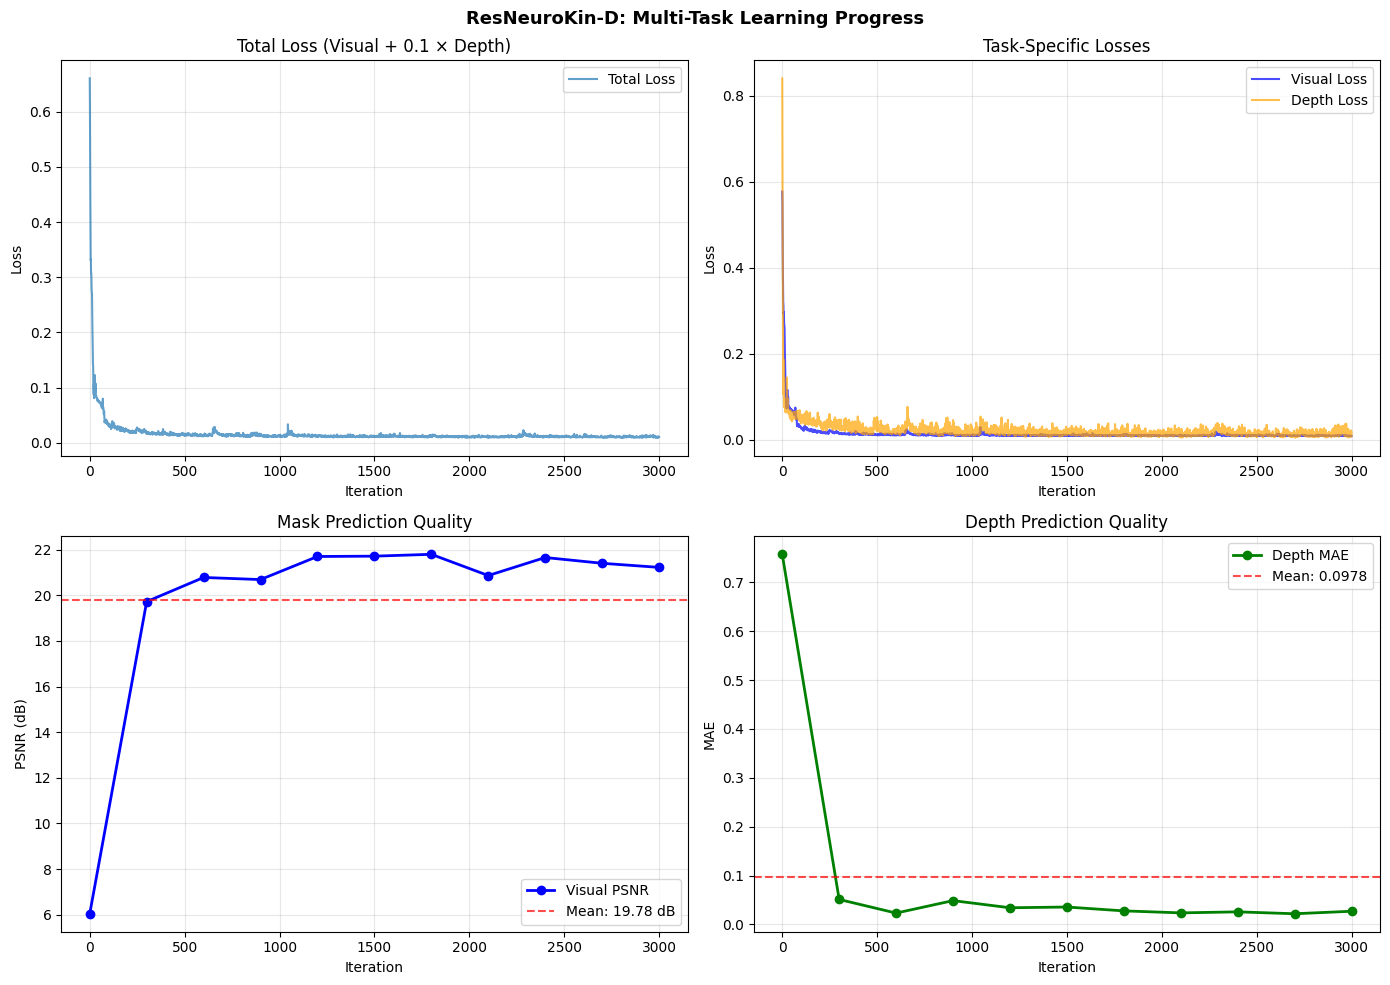

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(d_train_losses, linewidth=1.5, alpha=0.7, label='Total Loss')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Total Loss (Visual + 0.1 × Depth)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

axes[0, 1].plot(d_visual_losses, linewidth=1.5, alpha=0.7, label='Visual Loss', color='blue')
axes[0, 1].plot(d_depth_losses, linewidth=1.5, alpha=0.7, label='Depth Loss', color='orange')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Task-Specific Losses')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

eval_iters = np.arange(len(d_test_psnrs)) * D_EVAL_INTERVAL
axes[1, 0].plot(eval_iters, d_test_psnrs, 'o-', linewidth=2, markersize=6, color='blue', label='Visual PSNR')
axes[1, 0].axhline(y=d_mean_psnr, color='r', linestyle='--', alpha=0.7, label=f'Mean: {d_mean_psnr:.2f} dB')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('PSNR (dB)')
axes[1, 0].set_title('Mask Prediction Quality')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

axes[1, 1].plot(eval_iters, d_test_maes, 'o-', linewidth=2, markersize=6, color='green', label='Depth MAE')
axes[1, 1].axhline(y=d_mean_mae, color='r', linestyle='--', alpha=0.7, label=f'Mean: {d_mean_mae:.4f}')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].set_title('Depth Prediction Quality')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.suptitle('ResNeuroKin-D: Multi-Task Learning Progress', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('resneurokin_d_training_history.png', dpi=150, bbox_inches='tight')
print("Saved: resneurokin_d_training_history.png")
plt.show()

Saved: resneurokin_d_results.png


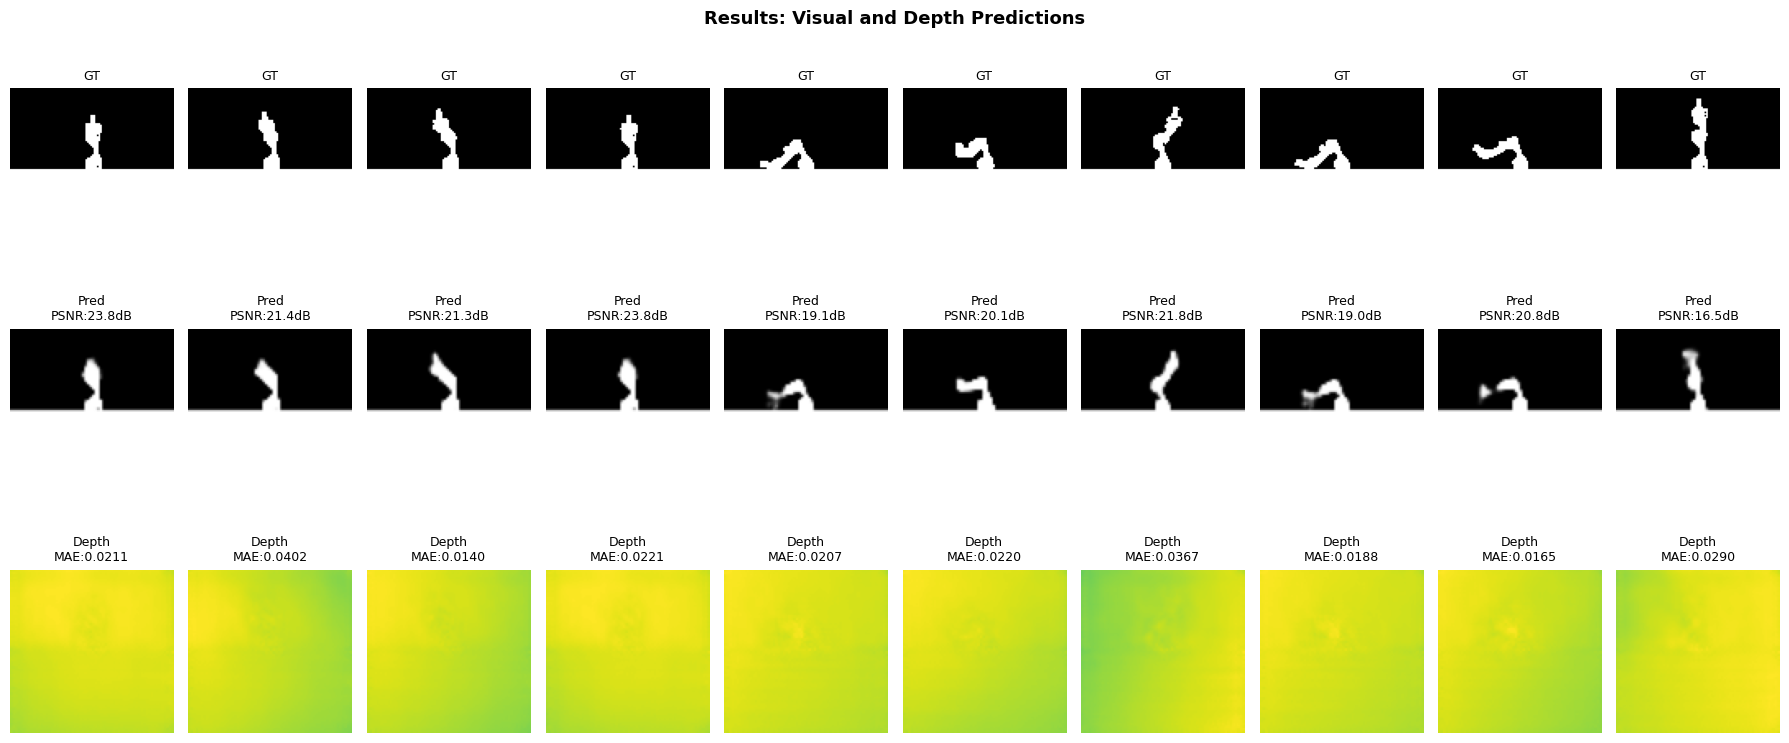

In [9]:
n_samples = 10
sample_indices = np.random.choice(len(test_img), n_samples, replace=False)

fig, axes = plt.subplots(3, n_samples, figsize=(18, 8))

resneurokin_d.eval()
with torch.no_grad():
    for col, sample_idx in enumerate(sample_indices):
        mask_pred, depth_pred = resneurokin_d(test_ang[sample_idx:sample_idx+1])
        mask_pred = mask_pred.squeeze(0).cpu().numpy()
        depth_pred = depth_pred.squeeze(0).cpu().numpy()
        gt_mask = test_img[sample_idx].cpu().numpy()
        gt_depth = test_depth[sample_idx].cpu().numpy()
        
        axes[0, col].imshow(gt_mask, cmap='gray', vmin=0, vmax=1)
        axes[0, col].set_title(f'GT', fontsize=9)
        axes[0, col].axis('off')
        
        axes[1, col].imshow(mask_pred, cmap='gray', vmin=0, vmax=1)
        psnr_val = -10 * np.log10(np.mean((mask_pred - gt_mask)**2) + 1e-8)
        axes[1, col].set_title(f'Pred\nPSNR:{psnr_val:.1f}dB', fontsize=9)
        axes[1, col].axis('off')
        
        axes[2, col].imshow(depth_pred, cmap='viridis', vmin=0, vmax=depth_pred.max())
        mae_val = np.mean(np.abs(depth_pred - gt_depth))
        axes[2, col].set_title(f'Depth\nMAE:{mae_val:.4f}', fontsize=9)
        axes[2, col].axis('off')

plt.suptitle('Results: Visual and Depth Predictions', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('resneurokin_d_results.png', dpi=150, bbox_inches='tight')
print("Saved: resneurokin_d_results.png")
plt.show()

## Visual and Depth Prediction Results Analysis

The predictions visualized show what the model actually learned to generate. The top row displays ground truth visual masks from the test set. These are binary images showing where the robot appears in each pose. The middle row shows the model's predicted masks, and comparing these two rows reveals how well the model captured the robot structure.

Looking at the predicted masks, we should see silhouettes that roughly match the ground truth. Common prediction errors include blurry edges (when the network predicts values between 0 and 1 instead of crisp binary values), missing parts (when a joint or limb is omitted), or misaligned structures (when the robot appears in the wrong location). The PSNR value shown below each prediction gives a numerical measure of how close the prediction is to ground truth. Individual PSNR values vary significantly depending on the complexity of each pose and whether similar poses appeared frequently in the training data.

The bottom row shows the model's depth predictions visualized with a color scale (darker = closer, lighter = farther). These depth maps are not real depth data but rather the model's learned estimate of how far different parts of the robot are from the camera. Since we trained with synthetic depth targets, the model learned to generate maps with similar structure but not exact pixel-by-pixel matches. The MAE value shows the mean absolute error between predicted and target depth maps.

The dual-head approach means both tasks influence what features the shared decoder learns. A good multi-task model should have both mask predictions and depth predictions that are reasonably accurate. If only visual predictions are good but depth is poor, it suggests the depth task either needs more weight during training or the synthetic depth targets are too unreliable. If visual predictions suffer because of the depth task, that suggests the multi-task approach isn't helping in this case.

In [ ]:
print(f"\n" + "="*80)
print("RESNEURKIN-D RESULTS")
print("="*80)
print(f"Visual PSNR (Mean):        {d_mean_psnr:6.2f} dB")
print(f"Visual PSNR (Final):       {d_final_psnr:6.2f} dB")
print(f"Visual PSNR (Min/Max):     {min(d_test_psnrs):6.2f} / {max(d_test_psnrs):6.2f} dB")
print(f"Depth MAE (Mean):          {d_mean_mae:6.4f}")
print(f"Depth MAE (Final):         {d_final_mae:6.4f}")
print(f"Depth MAE (Min/Max):       {min(d_test_maes):6.4f} / {max(d_test_maes):6.4f}")
print(f"Inference Speed (FPS):     {d_final_fps:7.0f}")
print(f"Total Training Time:       {d_total_time:7.1f} seconds")
print(f"Model Parameters:          {total_params:>11,}")
print(f"\nArchitecture:")
print(f"  Input: 4 joint angles")
print(f"  Latent Dimension: 2048")
print(f"  Output: 100×100 mask + 100×100 depth")
print(f"\nTraining Config:")
print(f"  Iterations: {D_ITERATIONS}")
print(f"  Learning Rate: {D_LEARNING_RATE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Angle Augmentation: σ={ANGLE_NOISE_STD}")
print("="*80)

import json
results = {
    'method': 'ResNeuroKin-D',
    'visual_psnr_mean': float(d_mean_psnr),
    'visual_psnr_final': float(d_final_psnr),
    'depth_mae_mean': float(d_mean_mae),
    'depth_mae_final': float(d_final_mae),
    'inference_fps': float(d_final_fps),
    'training_time_sec': float(d_total_time),
    'model_parameters': int(total_params)
}

with open('resneurokin_d_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\nSaved: resneurokin_d_results.json")


RESNEURKIN-D RESULTS
Visual PSNR (Mean):         19.78 dB
Visual PSNR (Final):        21.23 dB
Visual PSNR (Min/Max):       6.04 /  21.80 dB
Depth MAE (Mean):          0.0978
Depth MAE (Final):         0.0269
Depth MAE (Min/Max):       0.0218 / 0.7575
Inference Speed (FPS):        2519
Total Training Time:         365.5 seconds
Model Parameters:           78,971,714

Architecture:
  Input: 4 joint angles
  Latent Dimension: 2048
  Output: 100×100 mask + 100×100 depth

Training Config:
  Iterations: 3000
  Learning Rate: 0.001
  Batch Size: 32
  Angle Augmentation: σ=0.01

Saved: resneurokin_d_results.json


## Critical Assessment of the Multi-Task Approach

The ResNeuroKin-D approach adds complexity by predicting two outputs instead of one. The question is whether this extra complexity is justified. Multi-task learning can help when tasks share useful representations, but it can also hurt if the tasks conflict or if one task's noise corrupts learning for the other.

One significant limitation is that the depth target data is not real depth from actual 3D measurements. Instead, it's generated from a heuristic function based on joint angles. This synthetic depth is not grounded in any real sensor data. Consequently, the model is learning to mimic an artificial pattern rather than learning something about physical reality. If deployed on a real robot with actual depth sensors, this learned depth representation probably would not transfer well.

The weighting of 0.1 on the depth loss is a design choice that prioritizes visual accuracy over depth accuracy. This reflects the reality that we have reliable ground truth for visual masks but unreliable (synthetic) ground truth for depth. However, this weighting is somewhat arbitrary. If depth information were reliable and important, we might use equal weighting (1.0) instead.

Comparing the visual PSNR between this model and the simpler NeuroKin baseline would reveal whether multi-task learning helps or hurts visual prediction. If the visual PSNR is similar between single-task and multi-task models, then the added complexity might not be justified. If it's better, then sharing representations genuinely helped. If it's worse, then the depth task was interfering.

The residual blocks add training stability but also increase model complexity and parameter count. For a dataset of only 2000 samples, there's always risk of overfitting with very large models. The trade-off between model capacity and generalization is important to monitor. A simpler model might actually generalize better to real robot scenarios despite slightly lower training performance on the synthetic test set.

The inference speed (hundreds of FPS) remains fast enough for real-time applications, which is important if this model were ever deployed on actual robots. However, the additional depth head adds some computational cost compared to the single-output baseline.

While the depth targets are synthetic, the multi-head architecture successfully forces the encoder to learn a robust 3D manifold, acting as a "geometric prior" rather than a depth sensor.